In [63]:
import pandas as pd
import json

In [2]:
hrv_raw = pd.read_csv('./Fitbit/ShiYangLee/Sleep/daily_hrv_full.csv')
hrv_raw.head()

,timestamp,rmssd,nremhr,entropy
0,2022-02-27T00:00:00,52.053,53.789,2.833
1,2022-02-28T00:00:00,61.281,49.983,2.935
2,2022-03-01T00:00:00,59.392,50.798,2.943
3,2022-03-02T00:00:00,56.437,54.837,2.829
4,2022-03-03T00:00:00,54.982,52.368,2.927


In [3]:
hrv_raw.set_index('timestamp', inplace = True)

In [14]:
hrv_raw.index = pd.to_datetime(hrv_raw.index, format = '%Y-%m-%d')
# hrv_raw.index = hrv_raw.index.to_series().dt.strftime('%Y-%m-%d')

<AxesSubplot:xlabel='timestamp'>

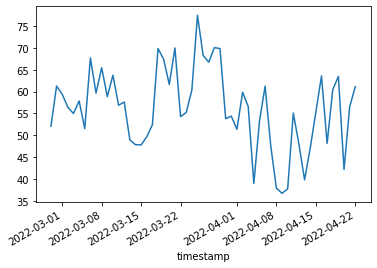

In [15]:
hrv_raw['rmssd'].plot()

In [19]:
hrv_raw['hrv_rolling'] = hrv_raw['rmssd'].rolling(7, 3, center = True).mean()

<AxesSubplot:xlabel='timestamp'>

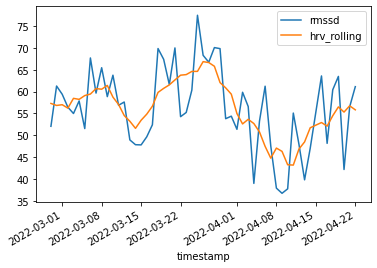

In [20]:
hrv_raw[['rmssd', 'hrv_rolling']].plot()

In [42]:
steps_raw = pd.read_csv('./Fitbit/ShiYangLee/Physical Activity/steps_full.csv')
steps_raw

,dateTime,value
0,2022-02-26 22:15:00,0
1,2022-02-26 22:16:00,5
2,2022-02-26 22:17:00,0
3,2022-02-26 22:18:00,0
4,2022-02-26 22:19:00,0
...,...,...
39856,2022-04-23 18:01:00,0
39857,2022-04-23 18:02:00,0
39858,2022-04-23 18:03:00,0
39859,2022-04-23 18:04:00,0


In [43]:
steps_raw.set_index('dateTime', inplace = True)
steps_raw.index = pd.to_datetime(steps_raw.index)
steps_per_day = steps_raw.groupby(steps_raw.index.to_series().dt.date).sum()
steps_per_day.index = pd.to_datetime(steps_per_day.index)

In [44]:
steps_per_day.head()

,value
dateTime,
2022-02-26,60
2022-02-27,2542
2022-02-28,6426
2022-03-01,9602
2022-03-02,7721


In [50]:
hrv = hrv_raw.merge(steps_per_day, left_index=True, right_index=True)

In [57]:
hrv['steps_normalized'] = hrv['value']/100
hrv['steps_rolling'] = hrv['steps_normalized'].rolling(7, 3, center = True).mean()

<AxesSubplot:>

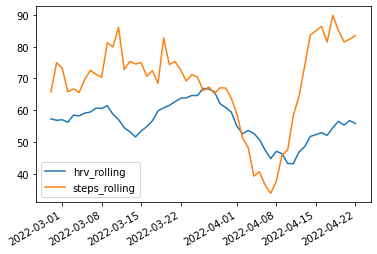

In [60]:
hrv[['hrv_rolling', 'steps_rolling']].plot()

In [71]:
sleep = pd.read_json('./Fitbit/ShiYangLee/Sleep/sleep-2022-03-27.json')
sleep.head()

,logId,dateOfSleep,startTime,endTime,duration,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,timeInBed,efficiency,type,infoCode,levels,mainSleep
0,36625185402,2022-04-24,2022-04-23T22:20:30.000,2022-04-24T09:35:30.000,40500000,0,568,107,0,675,96,stages,0,"{'summary': {'deep': {'count': 5, 'minutes': 9...",True
1,36617451798,2022-04-23,2022-04-23T13:25:00.000,2022-04-23T14:56:00.000,5460000,0,80,11,0,91,88,classic,2,"{'summary': {'restless': {'count': 4, 'minutes...",False
2,36613912467,2022-04-23,2022-04-22T23:23:00.000,2022-04-23T11:20:30.000,43020000,0,623,94,0,717,93,stages,0,"{'summary': {'deep': {'count': 7, 'minutes': 1...",True
3,36600884643,2022-04-22,2022-04-21T23:13:00.000,2022-04-22T07:21:30.000,29280000,0,436,52,0,488,97,stages,0,"{'summary': {'deep': {'count': 1, 'minutes': 3...",True
4,36595887971,2022-04-21,2022-04-21T17:09:00.000,2022-04-21T18:34:00.000,5100000,0,82,3,0,85,96,classic,2,"{'summary': {'restless': {'count': 2, 'minutes...",False


In [70]:
pd.read_json(sleep['levels'])

TypeError: argument of type 'method' is not iterable